In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import skew, kurtosis

import warnings
warnings.filterwarnings('ignore')

In [2]:
symbol = "BNBUSDT"
## Window
input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500"
df = pd.read_csv(rf"{input_path}\{symbol}.csv")

## Macbook
# input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500"
# df = pd.read_csv(f"{input_path}/{symbol}.csv")
try:
    df = df.drop(columns=["Unnamed: 0"])
except:
    pass

In [3]:
# Dữ liệu thô khi tải từ Binance về
df.head()

,a,p,q,f,l,T,m,M
0,714586811,856.95,0.012,1153229029,1153229029,1757139824320,False,True
1,714586812,856.94,0.081,1153229030,1153229030,1757139824807,True,True
2,714586813,856.95,0.018,1153229031,1153229031,1757139824897,False,True
3,714586814,856.95,0.011,1153229032,1153229032,1757139825301,False,True
4,714586815,856.94,0.321,1153229033,1153229033,1757139825328,True,True


In [4]:
cols = [
    "tradeId",
    "price",
    "quantity",
    "firstTradeId",
    "lastTradeId",
    "timestamp",
    "buyerMaker",
    "bestPriceMatch",
]
df.columns = cols
df = df[["timestamp", "price", "quantity", "buyerMaker"]]
df.head()


,timestamp,price,quantity,buyerMaker
0,1757139824320,856.95,0.012,False
1,1757139824807,856.94,0.081,True
2,1757139824897,856.95,0.018,False
3,1757139825301,856.95,0.011,False
4,1757139825328,856.94,0.321,True


In [5]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
df = df[["datetime", "price", "quantity", "buyerMaker"]]
df.head()

,datetime,price,quantity,buyerMaker
0,2025-09-06 06:23:44.320000+00:00,856.95,0.012,False
1,2025-09-06 06:23:44.807000+00:00,856.94,0.081,True
2,2025-09-06 06:23:44.897000+00:00,856.95,0.018,False
3,2025-09-06 06:23:45.301000+00:00,856.95,0.011,False
4,2025-09-06 06:23:45.328000+00:00,856.94,0.321,True


In [6]:
df.tail()

,datetime,price,quantity,buyerMaker
3999995,2025-08-24 18:36:21.909000+00:00,881.90,0.024,True
3999996,2025-08-24 18:36:21.921000+00:00,881.90,0.013,True
3999997,2025-08-24 18:36:21.963000+00:00,881.90,0.029,True
3999998,2025-08-24 18:36:21.963000+00:00,881.89,0.020,True
3999999,2025-08-24 18:36:21.964000+00:00,881.89,0.487,True


In [7]:
df['datetime'] = df['datetime'].dt.floor('S')
df.head()

,datetime,price,quantity,buyerMaker
0,2025-09-06 06:23:44+00:00,856.95,0.012,False
1,2025-09-06 06:23:44+00:00,856.94,0.081,True
2,2025-09-06 06:23:44+00:00,856.95,0.018,False
3,2025-09-06 06:23:45+00:00,856.95,0.011,False
4,2025-09-06 06:23:45+00:00,856.94,0.321,True


- buyerMaker cho biết buyer là maker hay taker:
    - buyerMaker = False → buyer là taker (mua chủ động ăn ask) ⇒ buy-initiated, giá khớp ở ask side
    - buyerMaker = True  → buyer là maker (đặt bid chờ, bị sell chủ động đập vào) ⇒ sell-initiated, giá khớp ở bid side
- => Hướng trade luôn xác định theo bên chủ động (taker).

In [8]:
df['side'] = np.where(df['buyerMaker'], 'sell', 'buy')
df.head()

,datetime,price,quantity,buyerMaker,side
0,2025-09-06 06:23:44+00:00,856.95,0.012,False,buy
1,2025-09-06 06:23:44+00:00,856.94,0.081,True,sell
2,2025-09-06 06:23:44+00:00,856.95,0.018,False,buy
3,2025-09-06 06:23:45+00:00,856.95,0.011,False,buy
4,2025-09-06 06:23:45+00:00,856.94,0.321,True,sell


In [9]:
agg = (df.groupby(['datetime', 'side'])
         .agg(price_mean=('price', 'mean'),
              qty_sum=('quantity', 'sum'))
         .reset_index()
         )

In [10]:
price_wide = agg.pivot(index='datetime', columns='side', values='price_mean').add_prefix('price_')
qty_wide   = agg.pivot(index='datetime', columns='side', values='qty_sum').add_prefix('qty_')


In [11]:
out_df = pd.concat([price_wide, qty_wide], axis=1).fillna(0.0)
out_df = out_df[['price_buy', 'price_sell', 'qty_buy', 'qty_sell']].sort_index()
out_df.head()

side,price_buy,price_sell,qty_buy,qty_sell
datetime,,,,
2025-08-24 18:34:28+00:00,881.640645,881.600000,32.800,10.067
2025-08-24 18:34:29+00:00,881.607000,881.562857,9.447,14.137
2025-08-24 18:34:30+00:00,881.442727,881.467143,2.500,6.577
2025-08-24 18:34:31+00:00,881.450000,881.440000,0.028,0.031
2025-08-24 18:34:32+00:00,881.503793,881.600000,13.636,0.008


In [12]:
# # Check lại một số vị trí có NaN
# date_test = out_df.index[-1]
# df[df["datetime"] == date_test]

In [13]:
# date_test = out_df.index[0]
# df[df["datetime"] == date_test]

# Tính toán các tham số đầu vào

In [14]:
window = 50
h = 50

## Tính V - Dùng để chia Volume Bucket

In [15]:
# Tính V
out_df["total_qty"] = out_df["qty_buy"] + out_df["qty_sell"]
# resample theo ngày
daily_vol = out_df["total_qty"].resample("D").sum()

# bỏ ngày đầu và ngày cuối vì không đủ dữ liệu
daily_vol = daily_vol.iloc[1:-1]
# Tính Volume Bucket
V = int(daily_vol.mean() / 50)
out_df = out_df.drop(columns=["total_qty"])
V

3356

## Chia Volume Buckets

In [16]:
def get_buckets(df, bucketSize: float) -> pd.DataFrame:
    d = df.copy()
    buckets = []
    BV = SV = filled = 0.0  # Buy Vol, Sell Vol, đã lấp đầy trong bucket hiện tại

    # tích lũy cho trung bình giá mua/bán
    bid_price_num = 0.0   # sum(alloc_buy * price_buy)
    ask_price_num = 0.0   # sum(alloc_sell * price_sell)
    total_price_num = 0.0 # sum((alloc_buy*price_buy + alloc_sell*price_sell))

    for ts, row in d.iterrows():
        buy_remain  = float(row['qty_buy'])
        sell_remain = float(row['qty_sell'])
        total_remain = buy_remain + sell_remain

        while total_remain > 0:
            space = bucketSize - filled
            take = min(space, total_remain)

            # phân bổ theo tỷ lệ buy/sell còn lại
            buy_share = (buy_remain / total_remain) if total_remain > 0 else 0.0
            alloc_buy = take * buy_share
            alloc_sell = take - alloc_buy

            # cộng dồn volume
            BV += alloc_buy
            SV += alloc_sell

            # cộng dồn cho từng loại giá
            if alloc_buy > 0:
                bid_price_num += alloc_buy * float(row['price_buy'])
                total_price_num += alloc_buy * float(row['price_buy'])
            if alloc_sell > 0:
                ask_price_num += alloc_sell * float(row['price_sell'])
                total_price_num += alloc_sell * float(row['price_sell'])

            # cập nhật trạng thái
            filled += take
            buy_remain  -= alloc_buy
            sell_remain -= alloc_sell
            total_remain = buy_remain + sell_remain

            # đủ bucket → ghi lại
            if filled >= bucketSize - 1e-12:
                total_vol = BV + SV
                bid_mean = (bid_price_num / BV) if BV > 0 else np.nan
                ask_mean = (ask_price_num / SV) if SV > 0 else np.nan
                avg_price = (total_price_num / total_vol) if total_vol > 0 else np.nan

                buckets.append({
                    'Time': ts,
                    'Buy': BV,
                    'Sell': SV,
                    'Price': avg_price,    # giá chung (VWAP toàn bucket)
                    'BidPrice': bid_mean,  # giá mua trung bình
                    'AskPrice': ask_mean   # giá bán trung bình
                })

                # reset cho bucket mới
                BV = SV = filled = 0.0
                bid_price_num = ask_price_num = total_price_num = 0.0

    return pd.DataFrame(buckets)


In [17]:
# # Xem thử kết quả
# df_buckets = get_buckets(out_df, V)
# df_buckets["volumn"] = df_buckets["Buy"] + df_buckets["Sell"]
# df_buckets

## Tính VPIN

In [18]:

def calc_vpin(df, bucketSize, window):
    df_buckets = get_buckets(df, bucketSize)
    df_buckets["Volume"] = df_buckets["Buy"] + df_buckets["Sell"]

    # VPIN: rolling mean của |Buy - Sell| / V
    df_buckets['VPIN'] = abs(df_buckets['Buy'] - df_buckets['Sell']).rolling(window).mean() / bucketSize

    # CDF:
    df_buckets['CDF'] = df_buckets['VPIN'].rank(pct=True)

    return df_buckets


In [19]:

data = calc_vpin(out_df, V, window)
data.tail()

,Time,Buy,Sell,Price,BidPrice,AskPrice,Volume,VPIN,CDF
632,2025-09-06 03:44:24+00:00,2044.705558,1311.294442,858.377442,858.444184,858.273370,3356.0,0.153843,0.801020
633,2025-09-06 04:04:29+00:00,1595.687000,1760.313000,859.023810,859.150403,858.909056,3356.0,0.152954,0.790816
634,2025-09-06 04:31:45+00:00,2023.063992,1332.936008,858.862635,858.915534,858.782347,3356.0,0.153817,0.799320
635,2025-09-06 04:49:39+00:00,1810.571153,1545.428847,857.136780,856.992857,857.305396,3356.0,0.149545,0.755102
636,2025-09-06 05:44:22+00:00,1440.601345,1915.398655,857.654130,857.670795,857.641596,3356.0,0.147919,0.727891


# Tính ROLL

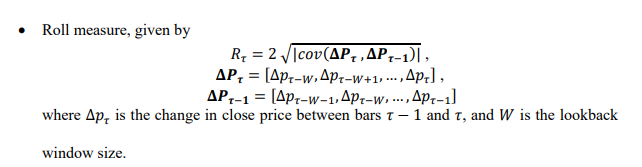

In [20]:
# Tính DeltaPrice:
data["DeltaPrice"] = data['Price'].diff()
data['DeltaPrice_lag'] = data['DeltaPrice'].shift(1)
data["Roll"] = 2* np.sqrt(abs(data["DeltaPrice"].rolling(window=window).cov(data["DeltaPrice_lag"])))


# Tính Roll impact

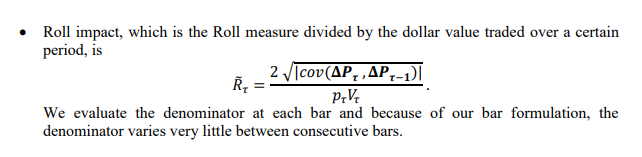

In [21]:
data["RollImpact"] = data["Roll"] / (data["Volume"]*data["Price"])
data.drop(["DeltaPrice", "DeltaPrice_lag"], axis=1, inplace=True)

# Tính Kyle’s lambda

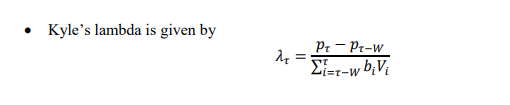
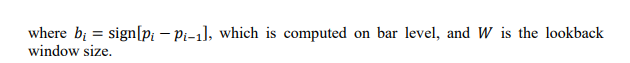

In [22]:
data["KyleLambda"] = (data["Price"].shift(window) - data["Price"]) / \
    ((data["Volume"] * np.sign(data['Price'].diff())).rolling(window=window).sum())

# Tính Amihud’s lambda

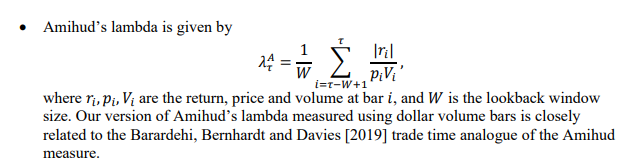

In [23]:
data['Returns'] = data['Price'].pct_change()
data["AmihudLambda"] = (1/window)/((abs(data['Returns']) /
                                  (data['Volume'] * data['Price'])).rolling(window=window).sum())

# Tính toán các biến khảo sát

### 1. Tính Dấu của sự thay đổi Bid-Ask Spread
- Trong bài báo đang tính dấu của sự thay đổi thông qua ước lượng  Corwin-Schultz, tuy nhiên bộ dữ liệu từ Binance cung cấp có thể tính toán được bid-ask rồi nên sẽ tính trực tiếp từ bộ dữ liệu 

In [24]:
data['BidAskSpread'] = data['AskPrice'] - data['BidPrice']
data['SpreadChangeSign'] = np.sign(data['BidAskSpread'].diff(h))

### 2. Tính dấu của biến động giá (Volatility) - Rolling Standard Deviation

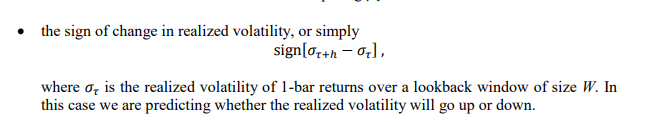

In [25]:
### Tính lợi suất (Returns) từ giá trung bình
# data['Returns'] = data['Price'].pct_change()
# Tính độ lệch chuẩn cuộn (Realized Volatility) và dấu hiệu thay đổi
data['RealizedVolatility'] = data['Returns'].rolling(window=window).std()
data['RealizedVolatilitySign'] = np.sign(data['RealizedVolatility'].diff(h))

### 3. Tính dấu của sự thay đổi trong thống kê Jarque-Bera của lợi suất thực tế

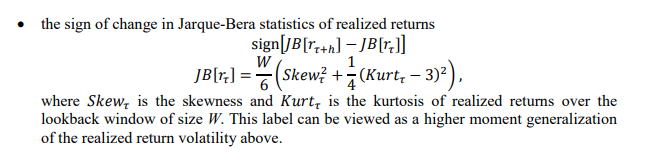

In [26]:
### Tính Skewness và Kurtosis
data['Skewness'] = data['Returns'].rolling(window=window).apply(skew)
data['Kurtosis'] = data['Returns'].rolling(window=window).apply(kurtosis)


In [27]:
def jarque_bera_statistic(skewness, kurtosis, window):
    # Tính Jarque-Bera Statistic theo công thức
    return (window / 6) * (skewness**2 + ((kurtosis - 3)**2) / 4)

In [28]:
data['JB_rolling'] = data.apply(lambda row: jarque_bera_statistic(
    row['Skewness'],
    row['Kurtosis'],
    window
)
    if not np.isnan(row['Skewness']) else np.nan, axis=1)

In [29]:
# Tính dấu của sự thay đổi trong thống kê Jarque-Bera
data['JB_ChangeSign'] = np.sign(data['JB_rolling'].diff(h))

### 4. Tính Dấu sự thay đổi trong tự tương quan bậc nhất của lợi suất thực tế

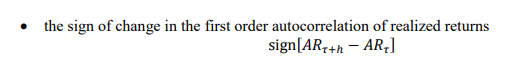
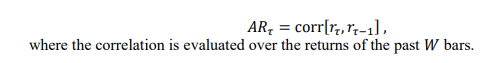

In [30]:
data['AR'] = data['Returns'].rolling(window=window).apply(lambda x: x.autocorr(lag=1), raw=False)
data['AR_ChangeSign'] = np.sign(data['AR'].diff(h))


### 5. Tính dấu của thay đổi trong độ lệch (skewness) tuyệt đối của lợi suất thực tế

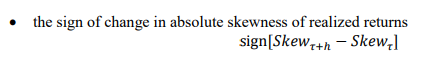

In [31]:
data['SkewnessSign'] = np.sign(data['Skewness'].diff(h))

### 6. Tính dấu của thay đổi trong trong độ nhọn (kurtosis)  của lợi suất thực tế

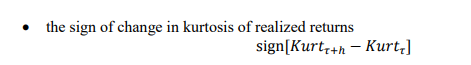

In [32]:
data['KurtosisSign'] = np.sign(data['Kurtosis'].diff(h))

# Lưu dữ liệu xuống

In [33]:
vpin_path = f"{input_path}/VPIN"
if not os.path.exists(vpin_path):
    os.makedirs(vpin_path)
data.to_csv(f"{vpin_path}/{symbol}.csv", index=False)